In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pyemu
from pathlib import Path
import os, shutil

In [5]:
ies_dir = Path('../tmprun/')

## take a look at the prior MC 

In [6]:
phi = pd.read_csv(ies_dir / 'mv.ies.phi.actual.csv').T.iloc[6:]
phi0 = phi[0]

<AxesSubplot: >

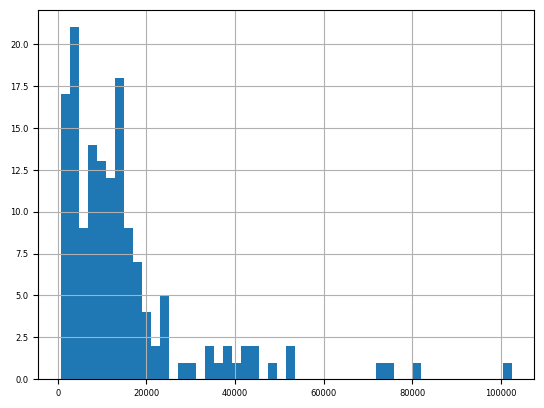

In [7]:
phi0.hist(bins=50)


In [8]:
phitoohigh = 25000
phi0 = phi0.loc[phi0 < phitoohigh]
phi0

0       19603.700
1        8402.130
2       10193.500
4       13481.900
5       11350.500
          ...    
144     13626.300
145      5473.080
147      8707.600
148     14769.800
base      646.904
Name: 0, Length: 131, dtype: float64

<AxesSubplot: >

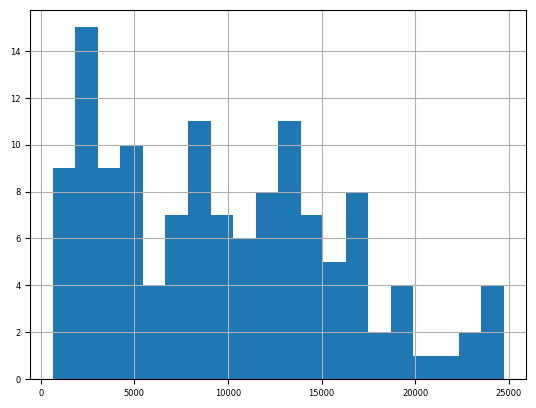

In [9]:
keep_reals0 = phi0.index
phi0.hist(bins=20)

## let's check out the observations

In [10]:
pst = pyemu.Pst(str(ies_dir / 'mv.ies.pst'))

In [11]:
obsdat = pst.observation_data.copy()
obsdat.sample(5)

,obsnme,obsval,weight,obgnme,standard_deviation
obsnme,,,,,
u14,u14,2.70,3.940438,headgroup,0.50
d_u01_w01,d_u01_w01,0.20,68.112277,head_diff,0.01
d_u13_w13,d_u13_w13,0.01,68.112277,head_diff,0.01
w14,w14,2.69,3.940438,headgroup,0.50
d_u15_w15,d_u15_w15,0.02,68.112277,head_diff,0.01


In [12]:
obs = pd.read_csv(ies_dir / 'mv.ies.0.obs.csv', index_col=0)
obs = obs.loc[keep_reals0]
obs_noise = pd.read_csv(ies_dir / 'mv.ies.obs+noise.csv', index_col=0)
obs_noise0 = obs_noise.loc[keep_reals0].copy()

In [13]:
with PdfPages('allobs.prior.pdf') as outpdf:
    for cc in obs.columns:
        plt.figure()
        ax = obs[cc].hist(bins=20, color='grey', alpha=.5, density=1)
        obs_noise0[cc].hist(bins=20, color='orange', alpha=.5, density=1)
        ax.axvline(obsdat.loc[cc].obsval, color='orange')
        plt.title(cc)
        if 'chd' in cc:
#             ax.set_ylim((0,1e-5))
            ax.set_yscale('log')
        plt.tight_layout()
        outpdf.savefig()
        plt.close('all')

[<Figure size 800x1050 with 0 Axes>, <Figure size 800x1050 with 8 Axes>]

<Figure size 800x1050 with 0 Axes>

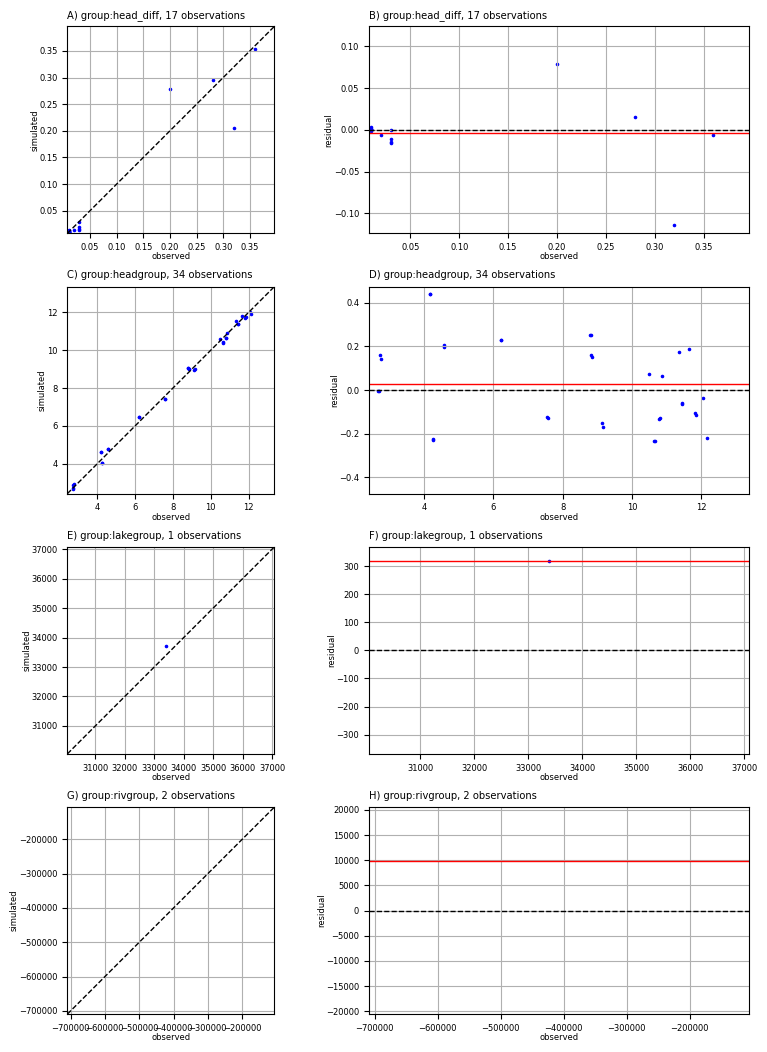

In [15]:
pst.plot(kind='1to1')

In [16]:
phi = pd.read_csv(ies_dir / 'mv.ies.phi.actual.csv').T.iloc[6:]
# for cc in phi.columns:
#     phi.loc[phi[cc]>1e6,cc] = np.nan

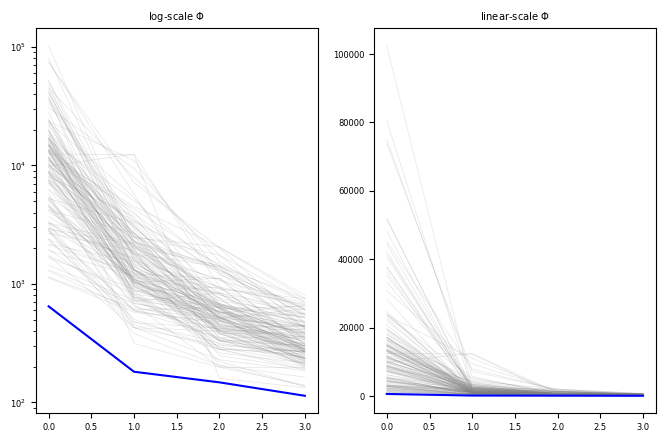

In [17]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
phi.T.plot(legend=False, color='grey',alpha=.2, lw=0.5, ax=ax[0])
phi.loc['base'].plot(color='b', ax=ax[0])
ax[0].set_yscale('log')
ax[0].set_title('log-scale $\\Phi$')
phi.T.plot(legend=False, color='grey',alpha=.2, lw=0.5, ax=ax[1])
phi.loc['base'].plot(color='b', ax=ax[1])
ax[1].set_title('linear-scale $\\Phi$');


In [18]:
citer = 2
obs_final = pd.read_csv(ies_dir / f'mv.ies.{citer}.obs.csv', index_col=0)

<AxesSubplot: >

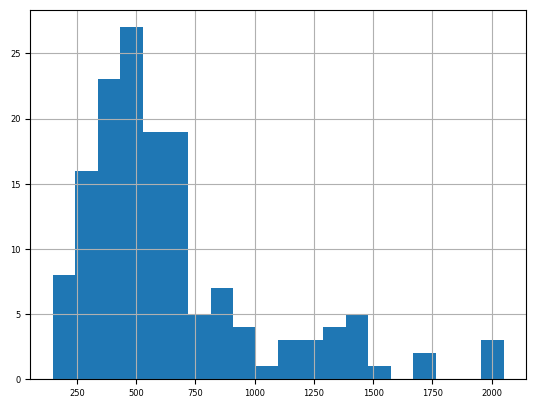

In [19]:
phi[citer].hist(bins=20)

<AxesSubplot: >

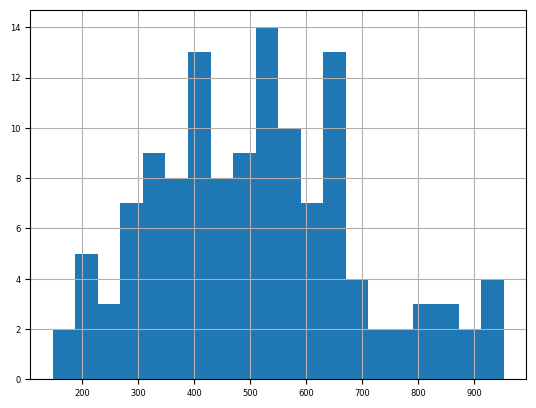

In [20]:
phitoohigh_final = 1000
phi_final = phi[citer].loc[phi[citer]<phitoohigh_final].copy()
keep_reals_final = phi_final.index
phi_final.hist(bins=20)

In [21]:
obs_final = obs_final.loc[keep_reals_final]
obs_final

,chdflow,d_u01_w01,d_u02_w02,d_u03_w03,d_u04_w04,d_u05_w05,d_u06_w06,d_u07_w07,d_u08_w08,d_u09_w09,...,w08,w09,w10,w11,w12,w13,w14,w15,w16,w17
0,2288.99,0.350756,0.283912,0.231469,0.001916,0.328952,0.003390,0.006622,0.015892,0.085231,...,9.26795,9.43964,10.94650,4.06296,4.03948,8.06411,3.09937,4.29489,2.72673,7.08379
1,15942.00,0.215753,0.210488,0.196111,0.021319,0.203458,0.023431,0.026829,0.037948,0.050687,...,8.18383,9.50064,10.74330,5.16499,5.10394,7.94894,2.92219,4.92129,3.13037,7.43053
3,34112.30,0.177505,0.159017,0.151454,0.007158,0.391590,0.021458,0.004972,0.036837,0.007033,...,8.75804,8.25670,10.68120,4.52115,4.71310,7.76606,3.25637,4.19957,3.13407,5.42581
4,7212.58,0.290083,0.243097,0.226318,0.014973,0.386495,0.013009,0.244120,0.024924,0.046142,...,9.06297,8.98648,9.89351,5.41400,6.13499,8.74109,2.63067,4.77464,2.76568,8.25770
5,24179.70,0.223757,0.260660,0.191123,0.066816,0.278482,0.011873,0.056452,0.061418,0.043624,...,9.28995,8.59399,9.40534,5.02468,4.58151,7.77210,2.42506,5.25547,3.60451,6.83183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,44198.20,0.282946,0.311225,0.208303,0.001993,0.440451,0.003756,0.005011,0.006141,0.030587,...,9.57829,8.32512,10.57590,3.89087,4.78248,7.06765,2.15323,5.46363,2.58964,6.41649
146,-6278.88,0.312189,0.229232,0.261223,0.007564,0.432823,0.033454,0.018306,0.038268,0.077135,...,9.14096,8.34613,10.54120,4.80684,4.04373,8.43388,2.46752,3.59657,2.03202,6.55801
147,21205.80,0.321256,0.322673,0.186932,0.003354,0.378977,0.005227,0.015133,0.026952,0.012537,...,9.88889,7.00134,10.58980,3.48093,4.29853,7.37934,2.11562,4.53030,1.81818,6.23818
148,43666.40,0.291030,0.322448,0.166686,0.004210,0.372852,0.008912,0.023850,0.021749,0.008350,...,8.76465,9.46949,10.52730,4.74244,3.84085,7.70294,2.58249,4.71504,2.60923,6.34424


[<Figure size 800x1050 with 0 Axes>, <Figure size 800x1050 with 8 Axes>]

<Figure size 800x1050 with 0 Axes>

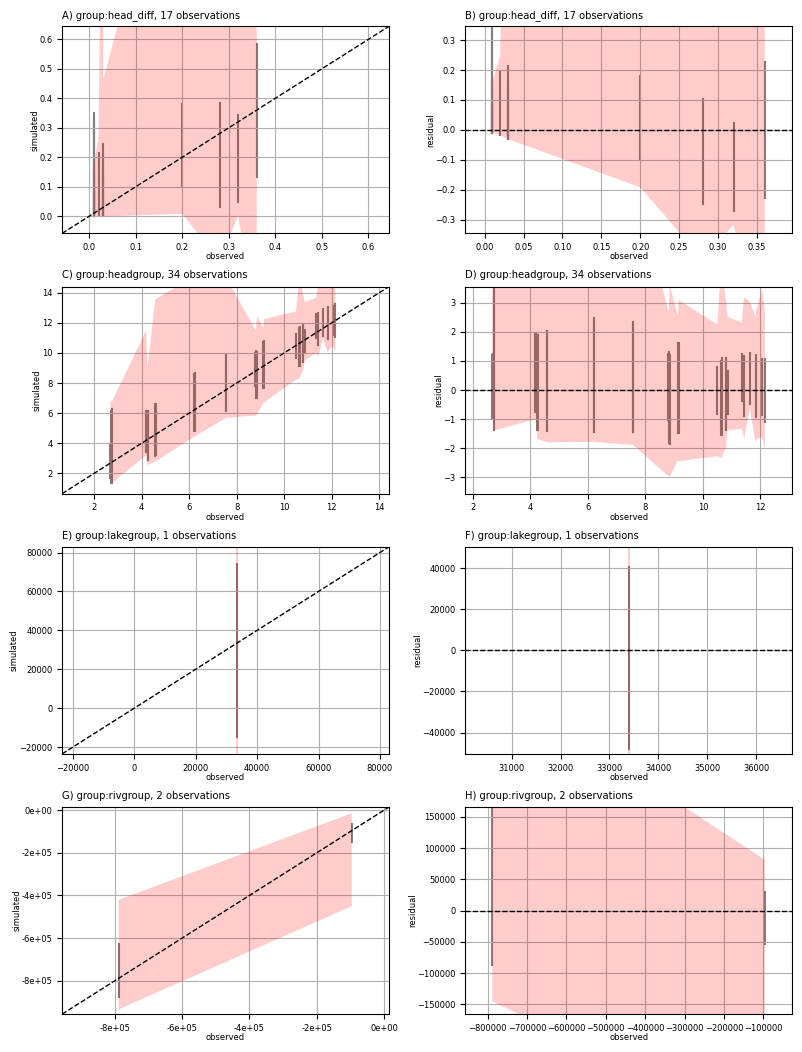

In [22]:
pyemu.plot_utils.ensemble_res_1to1(obs_final, pst, base_ensemble=obs)

In [23]:
obs_noise_final = obs_noise.loc[keep_reals_final]

In [24]:
obs

,chdflow,d_u01_w01,d_u02_w02,d_u03_w03,d_u04_w04,d_u05_w05,d_u06_w06,d_u07_w07,d_u08_w08,d_u09_w09,...,w08,w09,w10,w11,w12,w13,w14,w15,w16,w17
0,-208910.00,0.774483,0.933536,0.390867,0.003356,-0.085958,0.005872,0.007899,0.005260,0.454219,...,11.11970,11.98630,12.5346,4.73093,4.58697,10.17880,3.74878,5.26386,3.13131,9.02261
1,-125968.00,0.049991,0.061441,0.046497,0.016363,0.005614,0.034125,0.050091,0.114095,0.102787,...,7.82295,10.53100,12.1107,4.59090,6.24063,9.93397,2.96375,6.70762,2.95575,10.22440
2,-149578.00,0.010203,0.041190,0.010525,0.018464,0.034632,0.002940,0.025407,0.033175,0.002610,...,10.61620,10.52280,11.6053,3.63286,6.03706,10.56580,2.96415,4.61562,2.31744,10.57400
4,-172238.00,0.315213,0.004986,0.258335,0.017591,0.286147,0.018360,0.239757,0.026520,0.058223,...,9.85644,11.29000,12.3639,5.79311,8.45427,12.00700,2.70704,6.56127,3.06403,12.11220
5,-66747.70,0.758639,1.364430,0.519727,0.111457,0.785263,0.032041,0.057692,0.095985,0.099113,...,9.61220,8.87463,10.1684,6.25477,5.17596,8.56000,3.28178,5.87842,4.76261,7.59846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,-128452.00,0.772146,1.218580,0.387264,0.007386,0.934324,0.008113,0.080810,0.179870,0.027359,...,10.38260,8.80998,11.4609,2.92655,3.55050,7.74505,2.19976,4.34861,2.86917,6.02720
145,69416.60,0.671766,0.961907,0.407199,0.002370,0.898685,0.004540,0.003267,0.006357,0.018210,...,9.53134,8.46682,10.6165,4.60122,5.14047,7.61732,2.39138,5.96050,2.86008,6.95124
147,40323.30,0.910545,1.178600,0.312837,0.002027,0.908930,0.003644,0.007927,0.026876,0.006585,...,9.31255,5.99695,10.5973,3.43291,3.91724,7.21138,2.03850,4.60493,1.61266,6.64967
148,222470.00,0.635966,0.821882,0.306330,0.001862,0.978314,0.004384,0.006589,0.008951,0.001217,...,8.09607,8.58670,10.6888,5.19899,3.81752,8.37573,2.48837,5.09509,2.53336,8.16075


In [25]:
with PdfPages('allobs.posterior.pdf') as outpdf:
    for cc in obs.columns:
        plt.figure()
        ax = obs[cc].hist(bins=20, color='grey', alpha=.5, density=1)
        obs_noise_final[cc].hist(bins=20, color='orange', alpha=.5, density=1)
        obs_final[cc].hist(bins=20, color='blue', density=1, alpha=.7)
        ax.axvline(obsdat.loc[cc].obsval, color='orange')
        plt.title(cc)
        if 'chd' in cc:
#             ax.set_ylim((0,1e-5))
            ax.set_yscale('log')
        plt.tight_layout()
        outpdf.savefig()
        plt.close('all')

# Visualize a single set of fields

In [26]:
tmpdir = Path('../scratch')
if tmpdir.exists():
    shutil.rmtree(tmpdir)
shutil.copytree(ies_dir, tmpdir)

WindowsPath('../scratch')

In [27]:
pst = pyemu.Pst(str(tmpdir / 'mv.ies.pst'))

In [28]:
pars = pd.read_csv(ies_dir / f'mv.ies.{citer}.par.csv', index_col=0)
pars = pars.loc[keep_reals_final]

In [29]:
pst.control_data.noptmax=0

### good to check out the base realization, but could choose another

In [30]:
real_to_plot = 'base'

In [31]:
pst.parameter_data.loc[pars.loc[real_to_plot].index, 'parval1'] = pars.loc[real_to_plot]

In [32]:
pst.write(str(tmpdir / 'testrun.pst'), version=2)

noptmax:0, npar_adj:109, nnz_obs:54


In [33]:
pyemu.os_utils.run('pestpp-ies testrun.pst', str(tmpdir))

## viz the k fields

Text(0.5, 0.98, 'realization: base, iteration: 2')

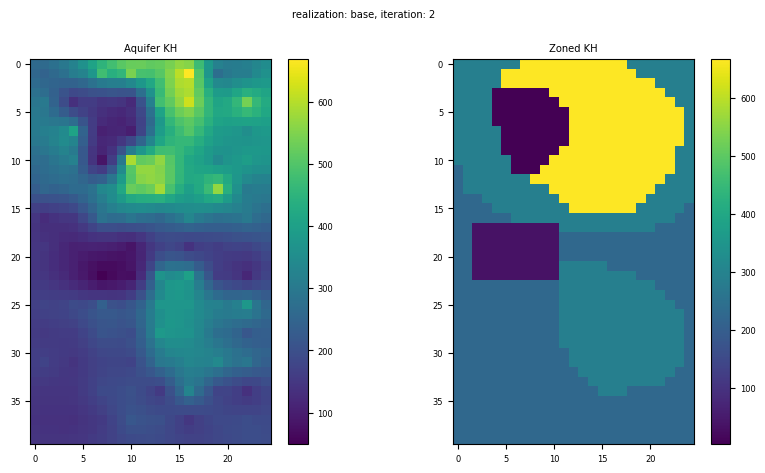

In [34]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
a = ax[0].imshow(np.loadtxt(tmpdir / 'k_aq.ref'))
plt.colorbar(a)
ax[0].set_title('Aquifer KH')
c = ax[1].imshow(np.loadtxt('../pest_background_files/k_aq.ref'))
ax[1].set_title('Zoned KH')
plt.colorbar(c)
plt.suptitle(f'realization: {real_to_plot}, iteration: {citer}')

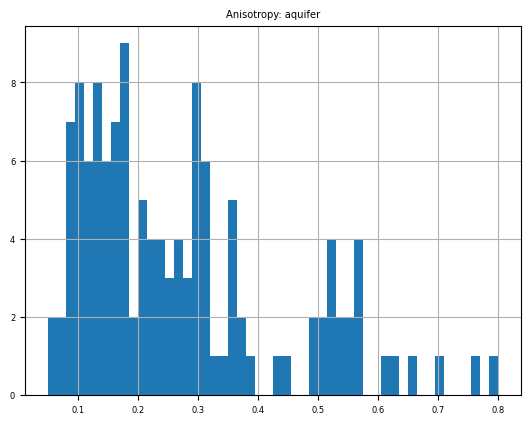

In [35]:
pars.kaniso.hist(bins=50)
plt.title('Anisotropy: aquifer');

Text(0.5, 1.0, 'Clay HK')

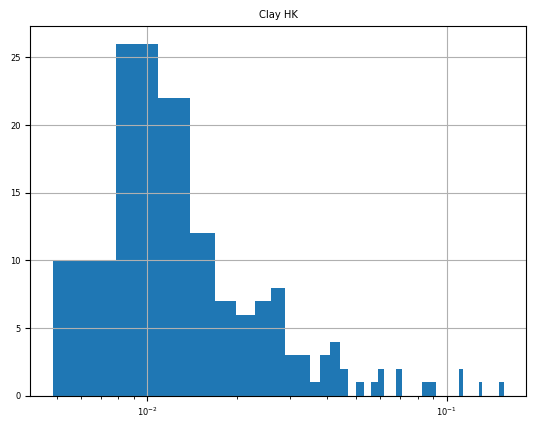

In [36]:
pars.hk_clay.hist(bins=50)
plt.xscale('log')
plt.title('Clay HK')

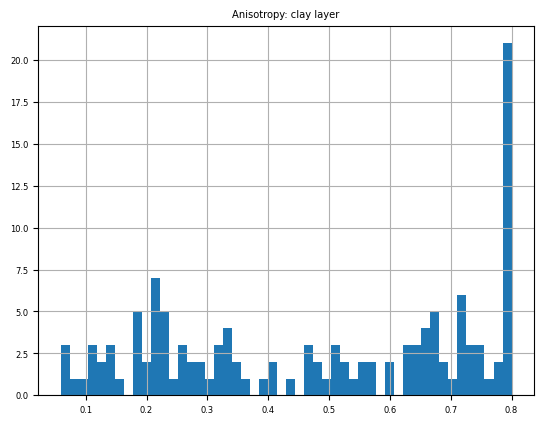

In [37]:
pars.kaniso_clay.hist(bins=50)
plt.title('Anisotropy: clay layer');

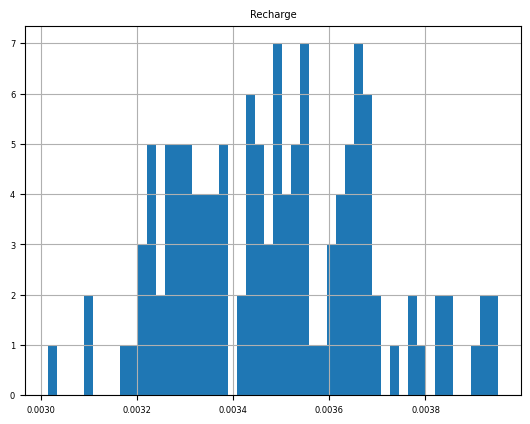

In [38]:
pars.rch.hist(bins=50)
plt.title('Recharge');

# viz the spatial residuals for heads

In [39]:
# read in the obs file to figure out the observation well locations

In [40]:
obsfile = [i.strip() for i in open('../pest_background_files/at.obs', 'r').readlines()]
j = 0
lox = []
for i in obsfile:
    if 'continuous' in i.lower():
        lox.append(j)
    j+=1
lox

[5, 23, 25, 43]

In [41]:
w_lox = pd.read_csv('../pest_background_files/at.obs', skiprows = lox[0]+1, nrows=17, delim_whitespace=True, header=None,
           names=['obsname','obstype','lay','row','col'], index_col=0)

u_lox = pd.read_csv('../pest_background_files/at.obs', skiprows = lox[2]+1, nrows=17, delim_whitespace=True, header=None,
           names=['obsname','obstype','lay','row','col'], index_col=0)
for cc in ['lay','row','col']:
    for clox in [w_lox,u_lox]:
        clox[cc] -=1


In [42]:
wobs = obs_final.T.loc[w_lox.index]
uobs = obs_final.T.loc[u_lox.index]

In [43]:
w_lox

,obstype,lay,row,col
obsname,,,,
w01,head,4,2,17
w02,head,3,3,10
w03,head,3,6,20
w04,head,3,12,22
w05,head,4,14,11
w06,head,3,16,18
w07,head,3,17,1
w08,head,3,18,6
w09,head,3,19,11


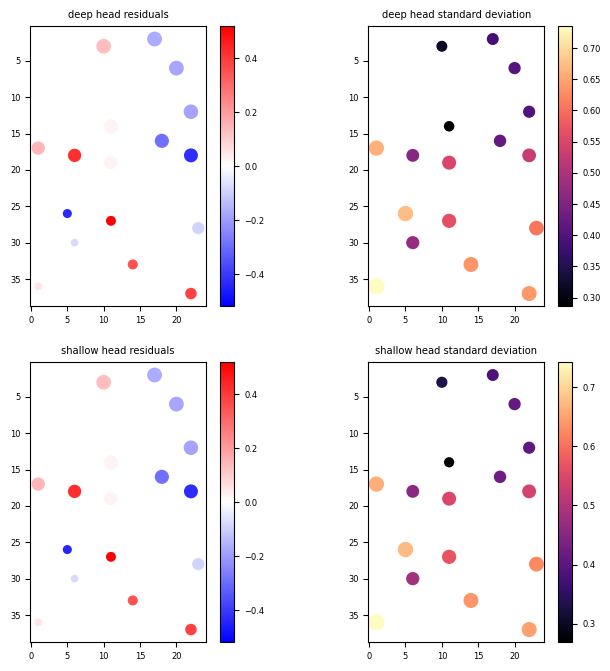

In [44]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
wres = wobs['base'].values-obsdat.loc[w_lox.index].obsval
d=ax[0,0].scatter(w_lox.col,w_lox.row, 
                  c=wres, 
                  s=wobs['base'].values*8,
                 cmap='bwr', vmin =-np.max(np.abs(wres)),
                 vmax=np.max(np.abs(wres)))
ax[0,0].invert_yaxis()
ax[0,0].set_title('deep head residuals')
plt.colorbar(d)
d=ax[0,1].scatter(w_lox.col,w_lox.row, c=wobs.T.std(), s=wobs.T.std()*150,  cmap='magma')
ax[0,1].set_title('deep head standard deviation')
ax[0,1].invert_yaxis()
plt.colorbar(d)

ures = uobs['base'].values-obsdat.loc[u_lox.index].obsval
d=ax[1,0].scatter(u_lox.col,u_lox.row, 
                  c=wres, 
                  s=wobs['base'].values*8,
                 cmap='bwr', vmin =-np.max(np.abs(ures)),
                 vmax=np.max(np.abs(ures)))
ax[1,0].set_title('shallow head residuals')
ax[1,0].invert_yaxis()
plt.colorbar(d)

d=ax[1,1].scatter(u_lox.col,u_lox.row, c=uobs.T.std(), s=uobs.T.std()*150, cmap='magma')
ax[1,1].set_title('shallow head standard deviation')
ax[1,1].invert_yaxis()

plt.colorbar(d)
for ax in ax.ravel():
    ax.set_aspect('equal')